# Hourly Time Series Forecasting using XGBoost and Prophet

### By Shahin Karami

In this Python Notebook I use XGBoost and Facebook's Prophet to predict hourly enery consumption using PJM East data. I compare the two Models using the MAPE and RSME to determine which model performs better. Then I create a one year forecast using the model that performed the best. I utilize Hourly PJM East Data from 2002 and 2018 found via [Kaggle](https://www.kaggle.com/code/robikscube/time-series-forecasting-with-prophet#Data-Cleaning). The data can also be downloaded via PJM's website. I first import the data and conduct basic EDA, next I build the up a XGBoost and Prophet model, lastly I evaluate the models and create an out of sample forecast.

<hr>

## 1 - Importing Packages and Data

In [811]:
import pandas as pd
from pandas.api.types import CategoricalDtype
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

import xgboost as xgb
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

##################################################################
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
##################################################################

import warnings
warnings.filterwarnings("ignore")

color_pal = sns.color_palette()
plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

In [812]:
df = pd.read_csv('PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

## 2 - Exploratory Data Analysis

### 2.1 - Outlier Removal and Basic Visualization

In [813]:
df.describe()

PJME_MW
count  145366.000000
mean    32080.222831
std      6464.012166
min     14544.000000
25%     27573.000000
50%     31421.000000
75%     35650.000000
max     62009.000000

First I visualize the data to get a sense of the data behavior. Since this is energy consumption data I expect to see alot of seasonality within the data.

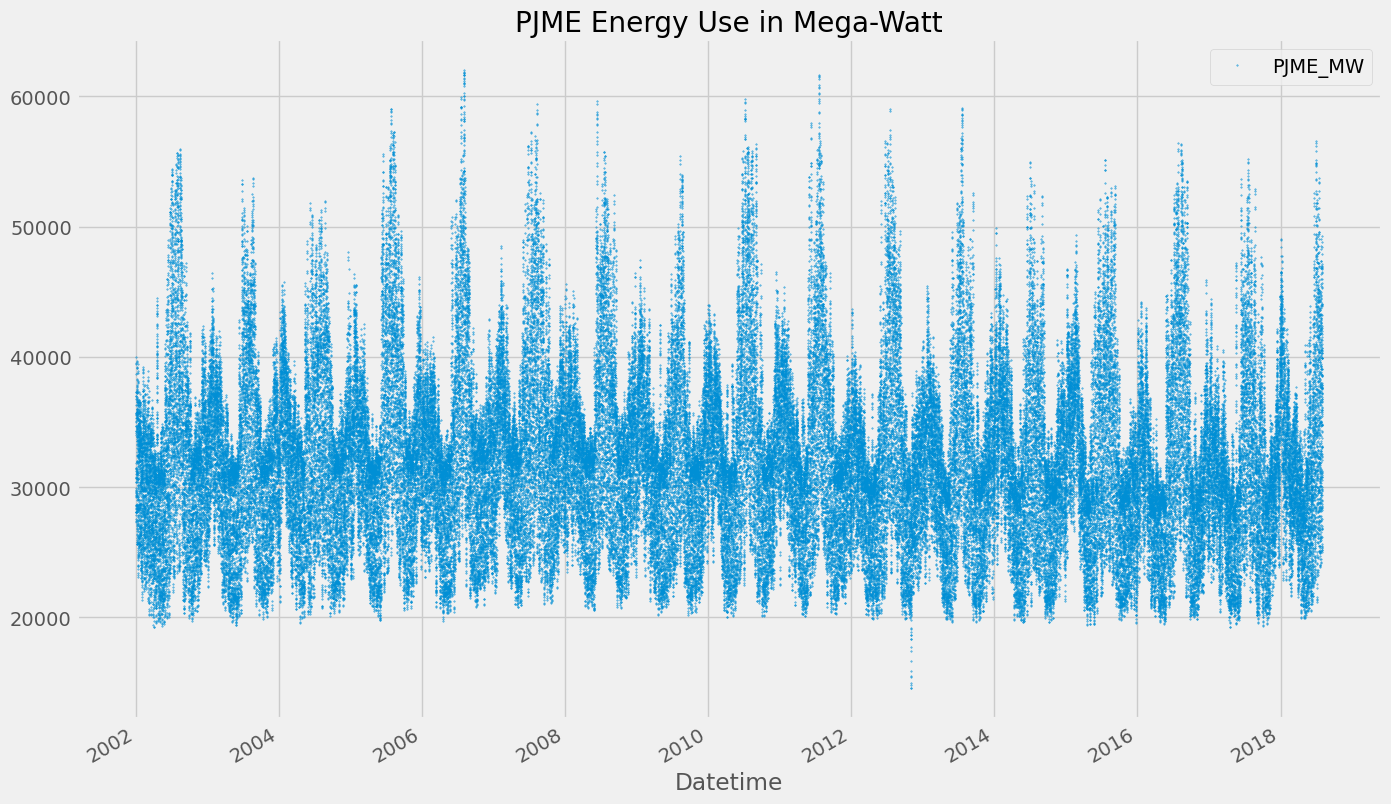

In [814]:
df.plot(style='.', figsize=(15, 10), color=color_pal[0], ms = .75, title='PJME Energy Use in Mega-Watt')
plt.show()

Based on our plots above it seems like there are have extreme outliers that are below 20000 MW. This looks to be an isolated occurance so it could be due to blackouts, faulty
sensors, or a one off events that led to a decline in energy use. 

<AxesSubplot:title={'center':'Outliers < 20,000'}, xlabel='Datetime'>

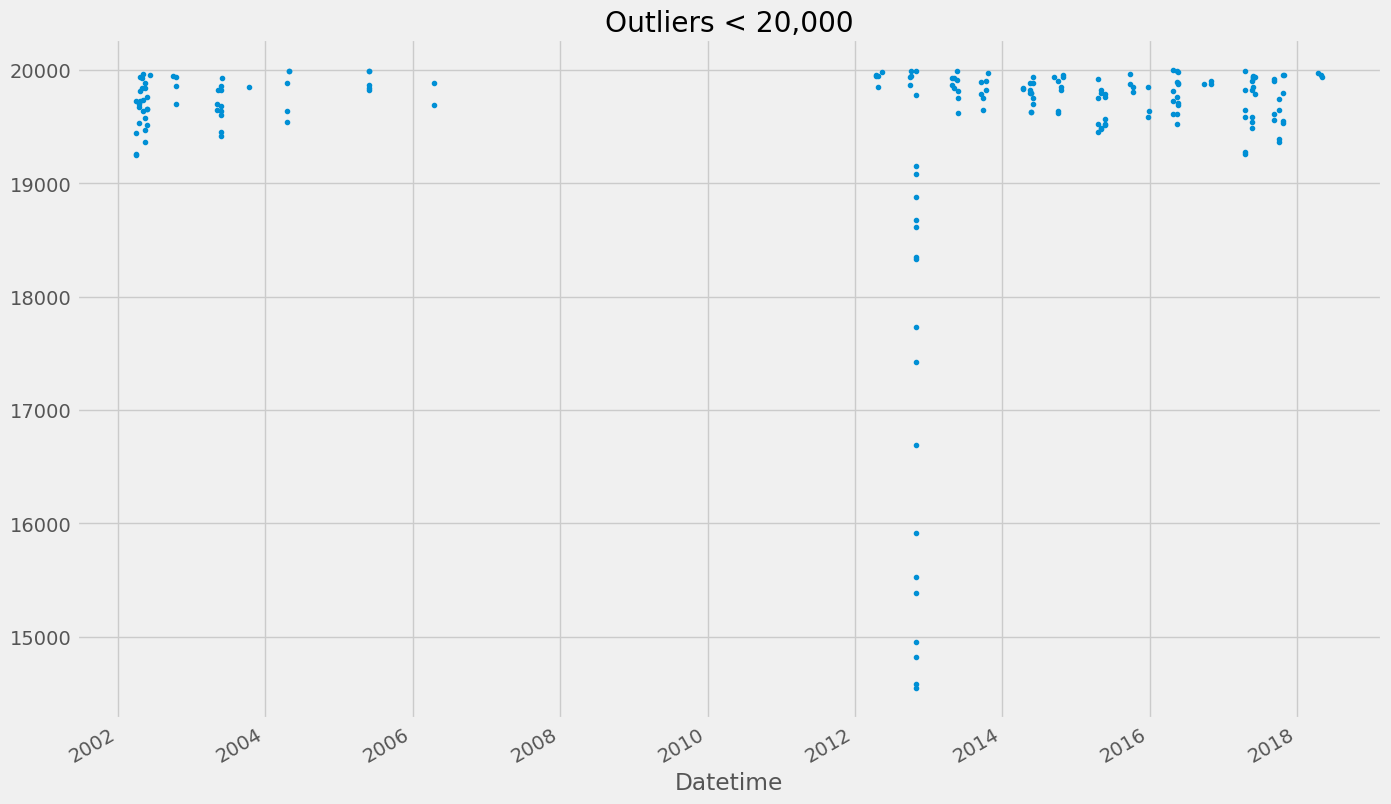

In [815]:
df.query('PJME_MW < 20_000')['PJME_MW'].plot(style='.',figsize=(15, 10),title='Outliers < 20,000')

It looks like the values below 19,000 are the most extreme outliers based on the plot above. In the plot below it looks like the cause of this is likely to be Superstorm Sandy, which was one of the most devasting Atlantic Hurricanes within the last 15 years. I visualize those data points a bit more to better understand the extreme outliers caused by the storm in late October 2012.

<AxesSubplot:title={'center':'Outliers'}, xlabel='Datetime'>

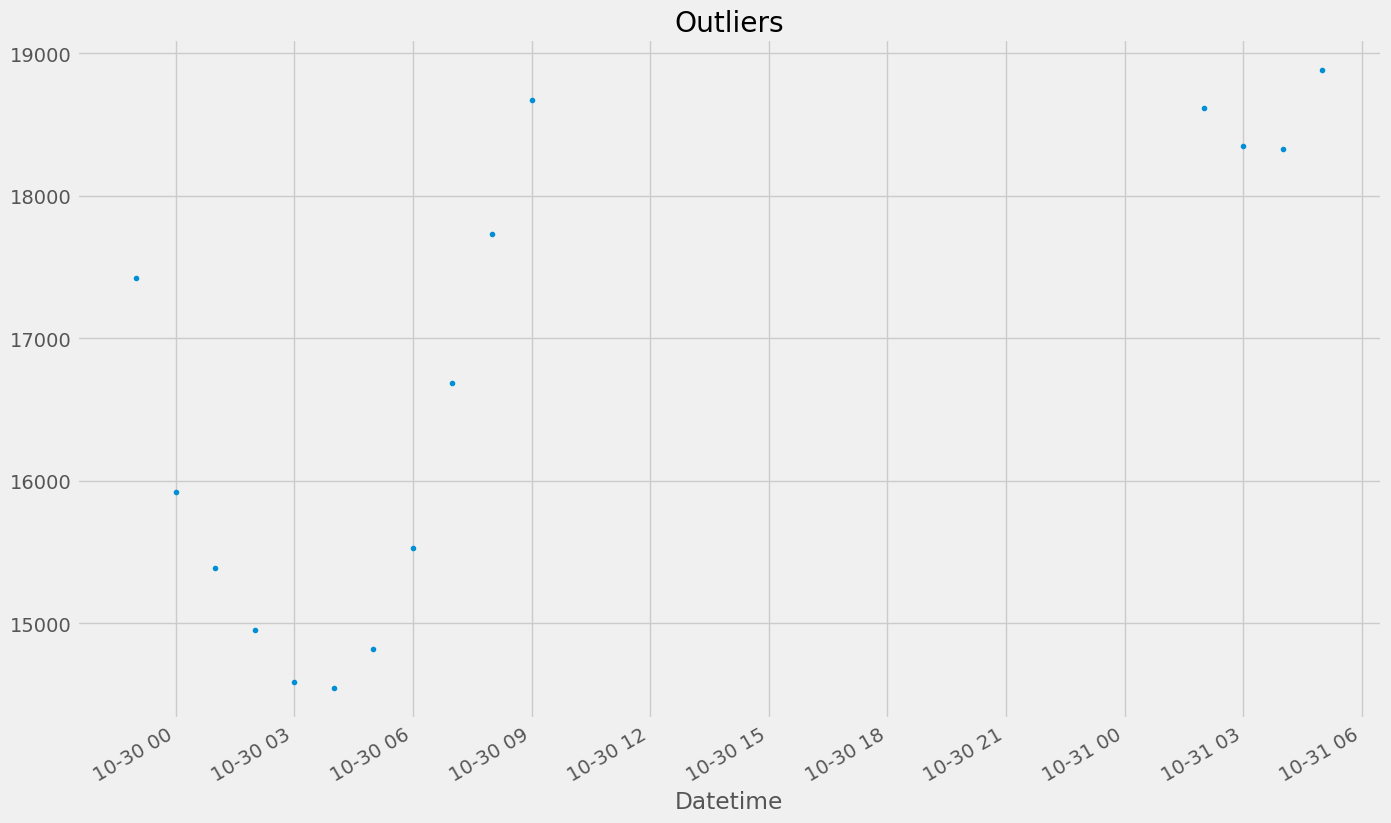

In [816]:
df.query('PJME_MW < 19_000')['PJME_MW'].plot(style='.',figsize=(15, 10),title='Outliers')

Since the only values below 19,000 were due to a black sheep event--Superstorm Sandy--and that there are only 15 data points out of 145,366 that are extreme outliers I will reassign those values to a value between 19,000 and 19,200. 

In [817]:
df.loc[df['PJME_MW'] < 19000, 'PJME_MW'] = np.random.uniform(19000, 19200)

In [818]:
# confirmation that the smallest value is not less than 19,000
df.min()

PJME_MW    19085.0
dtype: float64

Now I visualize the distribution of the data:

<AxesSubplot:ylabel='Frequency'>

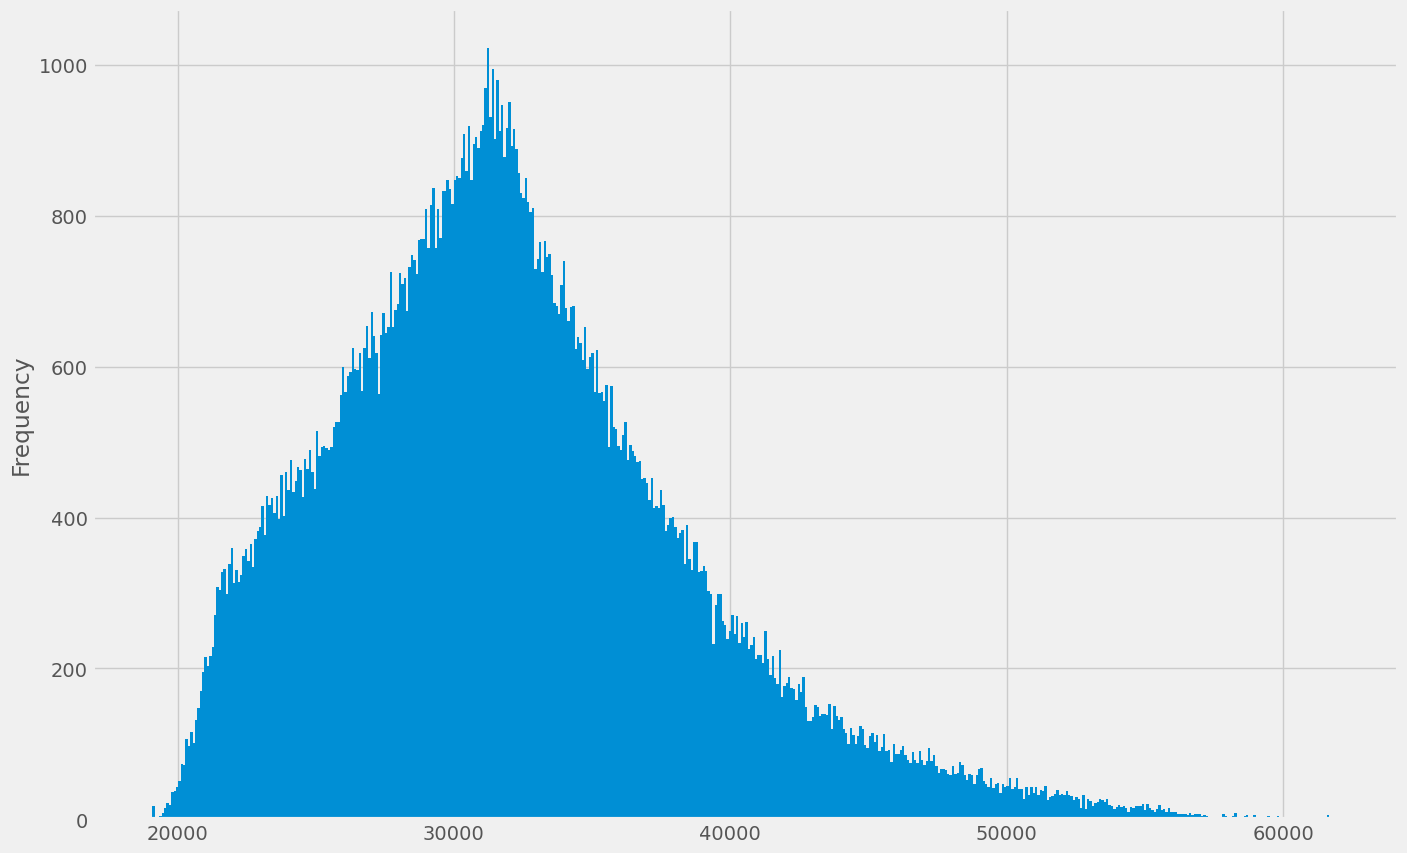

In [819]:
df['PJME_MW'].plot(figsize=(15, 10),kind='hist', bins=500)

Before I move to creating specific date related features I want to look at how the data may ebb and flow on any given week and month. After this, I will focus on visuallizing datetime features to properly capture datetime related trends.

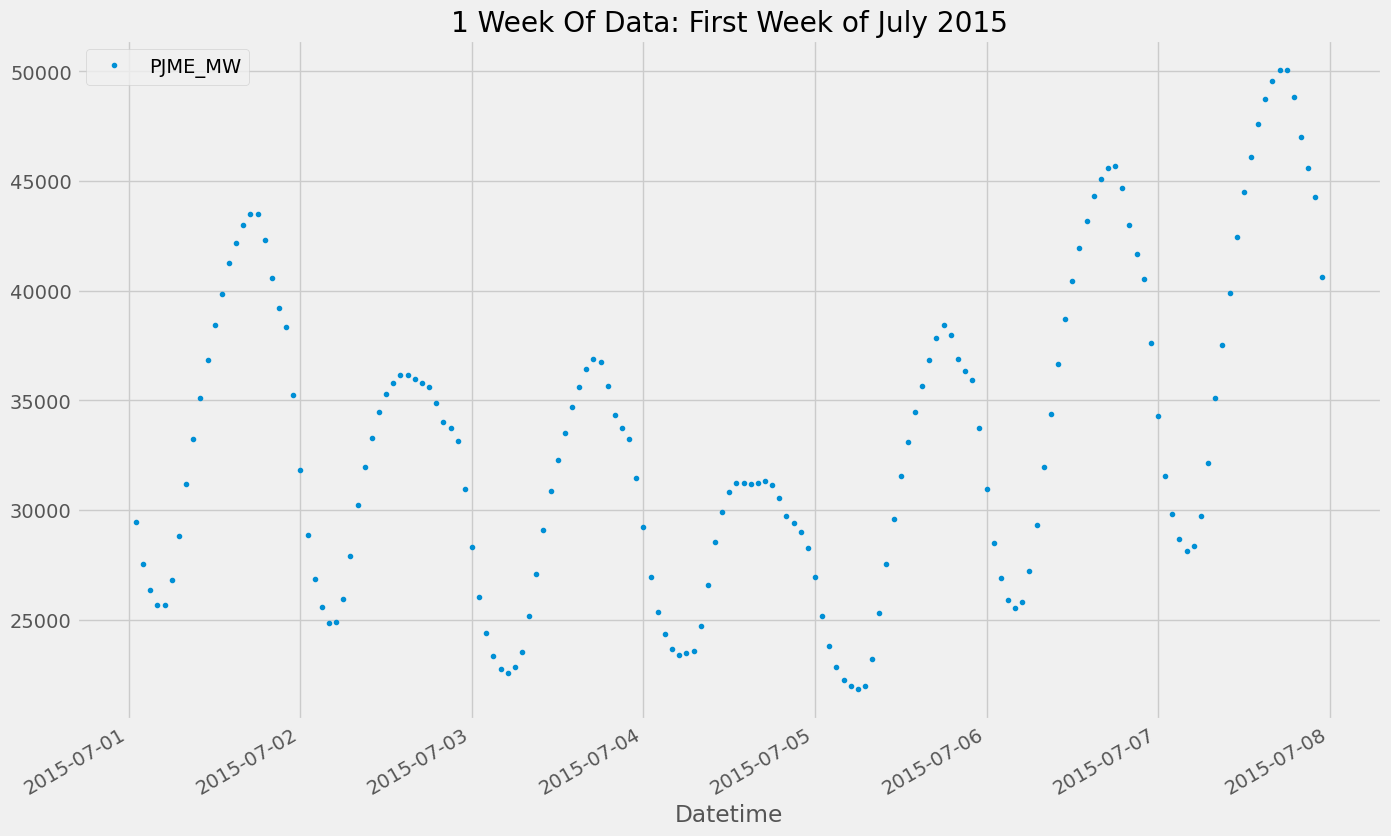

In [820]:
df.loc[(df.index > '07-01-2015') & (df.index < '07-08-2015')].plot(figsize=(15, 10), 
                                                                   title='1 Week Of Data: First Week of July 2015',
                                                                   style='.')
plt.show()

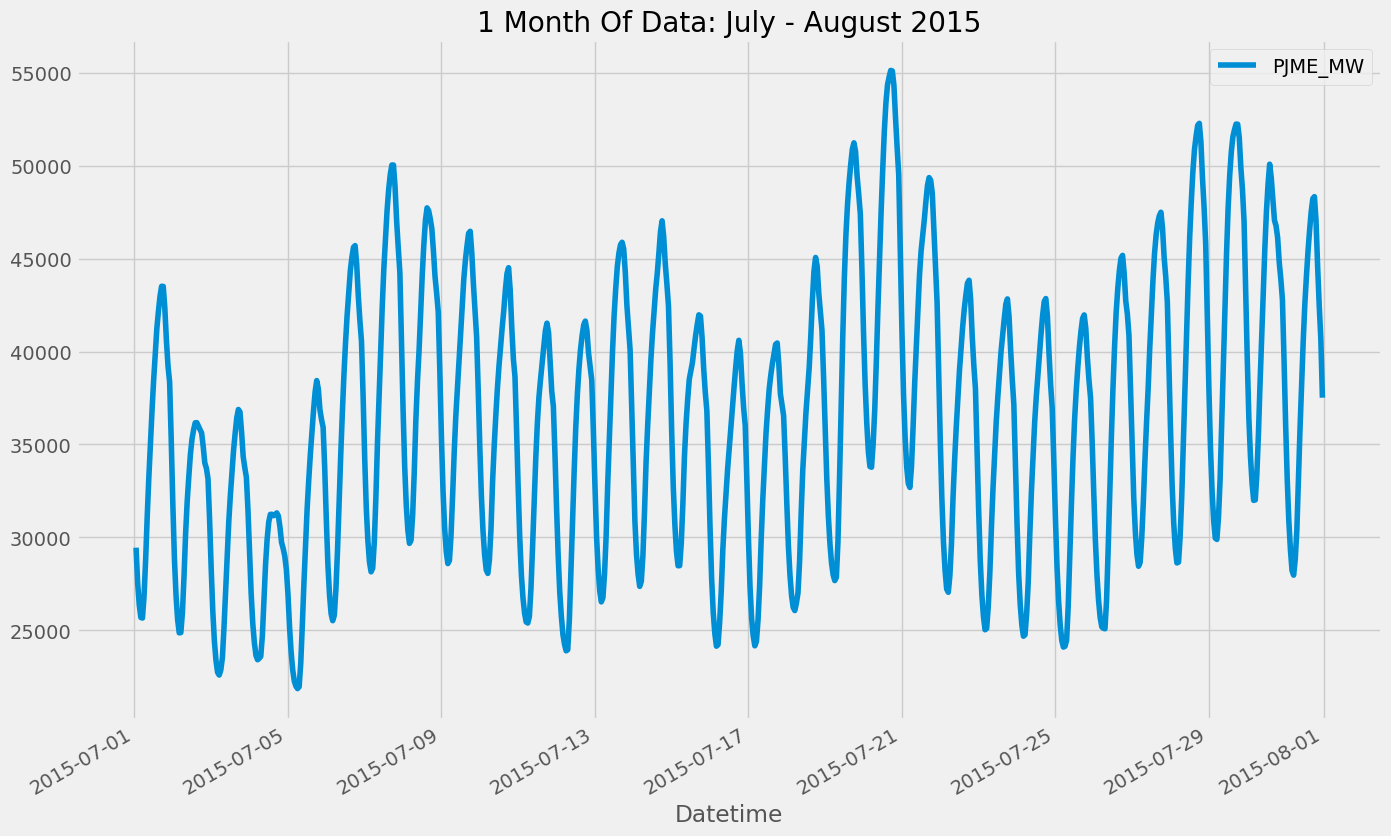

In [821]:
df.loc[(df.index > '07-01-2015') & (df.index < '08-01-2015')].plot(figsize=(15, 10), 
                                                                   title = '1 Month Of Data: July - August 2015',
                                                                   style = '-',
                                                                   ms = 1)
plt.show()

<hr>

### 2.1 - Feature Creation and Lag Features

Now I will create two functions. The `create_features` function will add Datetime related features, and the `add_lags` function which adds various lags to the data.

In [822]:
weekday_cat_type = CategoricalDtype(categories=['Monday','Tuesday',
                                        'Wednesday',
                                        'Thursday','Friday',
                                        'Saturday','Sunday'],
                            ordered=True)

month_cat_type = CategoricalDtype(categories=['January', 'February', 
                                              'March', 'April', 'May', 
                                              'June', 'July', 'August', 
                                              'September', 'October', 
                                              'November', 'December'],
                            ordered=True)


def create_features(df, pred = False):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['Date'] = df.index
    df['Hour'] = df['Date'].dt.hour
    df['Day of Week'] = df['Date'].dt.dayofweek
    df['Weekday'] = df['Date'].dt.day_name()
    df['Weekday'] = df['Weekday'].astype(weekday_cat_type)
    df['Month'] = df['Date'].dt.month_name()
    df['Month'] = df['Month'].astype(month_cat_type)
    df['Month of Year'] = df['Date'].dt.month
    df['Quarter'] = df['Date'].dt.quarter
    df['Year'] = df['Date'].dt.year
    df['Day of Year'] = df['Date'].dt.dayofyear
    df['Day of Month'] = df['Date'].dt.day
    df['Week of Year'] = df['Date'].dt.weekofyear
    df['Date_offset'] = (df.Date.dt.month*100 + df.Date.dt.day - 320)%1300

    df['Season'] = pd.cut(df['Date_offset'], [0, 300, 602, 900, 1300], 
                          labels=['Spring', 'Summer', 'Fall', 'Winter'])
    
    if pred == True:
        df = df[['PJME_MW','isFuture','Hour','Day of Week','Quarter','Month','Month of Year','Year',
                 'Day of Year','Day of Month','Week of Year','Weekday', 'Season']]
    if pred == False:
        df = df[['PJME_MW','Hour','Day of Week','Quarter','Month','Month of Year','Year',
                 'Day of Year','Day of Month','Week of Year','Weekday', 'Season']]
    return df



In [823]:
df_features = create_features(df)

In [824]:
df_features.shape

(145366, 12)

In [825]:
def add_lags(df):
    target_map = df['PJME_MW'].to_dict()
    df['1 Day Lag'] = (df.index - pd.Timedelta('1 days')).map(target_map) 
    df['2 Day Lag'] = (df.index - pd.Timedelta('2 days')).map(target_map)
    df['3 Day Lag'] = (df.index - pd.Timedelta('3 days')).map(target_map)
    df['1 Week Lag'] = (df.index - pd.Timedelta('7 days')).map(target_map)
    df['2 Week Lag'] = (df.index - pd.Timedelta('14 days')).map(target_map)
    df['1 Month Lag'] = (df.index - pd.Timedelta('30 days')).map(target_map)
    df['2 Month Lag'] = (df.index - pd.Timedelta('60 days')).map(target_map)
    df['1 Year Lag'] = (df.index - pd.Timedelta('364 days')).map(target_map) 
    df['2 Year Lag'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    return df

In [826]:
df_features_lags = add_lags(df_features)

In [827]:
df_features_lags.sort_index()

PJME_MW  Hour  Day of Week  Quarter    Month  \
Datetime                                                            
2002-01-01 01:00:00  30393.0     1            1        1  January   
2002-01-01 02:00:00  29265.0     2            1        1  January   
2002-01-01 03:00:00  28357.0     3            1        1  January   
2002-01-01 04:00:00  27899.0     4            1        1  January   
2002-01-01 05:00:00  28057.0     5            1        1  January   
...                      ...   ...          ...      ...      ...   
2018-08-02 20:00:00  44057.0    20            3        3   August   
2018-08-02 21:00:00  43256.0    21            3        3   August   
2018-08-02 22:00:00  41552.0    22            3        3   August   
2018-08-02 23:00:00  38500.0    23            3        3   August   
2018-08-03 00:00:00  35486.0     0            4        3   August   

                     Month of Year  Year  Day of Year  Day of Month  \
Datetime                                                              
2002-01-01 01:00:00              1  2002            1             1   
2002-01-01 02:00:00              1  2002            1             1   
2002-01-01 03:00:00              1  2002            1             1   
2002-01-01 04:00:00              1  2002            1             1   
2002-01-01 05:00:00              1  2002            1             1   
...                            ...   ...          ...           ...   
2018-08-02 20:00:00              8  2018          214             2   
2018-08-02 21:00:00              8  2018          214             2   
2018-08-02 22:00:00              8  2018          214             2   
2018-08-02 23:00:00              8  2018          214             2   
2018-08-03 00:00:00              8  2018          215             3   

                     Week of Year  ...  Season 1 Day Lag  2 Day Lag  \
Datetime                           ...                                
2002-01-01 01:00:00             1  ...  Winter       NaN        NaN   
2002-01-01 02:00:00             1  ...  Winter       NaN        NaN   
2002-01-01 03:00:00             1  ...  Winter       NaN        NaN   
2002-01-01 04:00:00             1  ...  Winter       NaN        NaN   
2002-01-01 05:00:00             1  ...  Winter       NaN        NaN   
...                           ...  ...     ...       ...        ...   
2018-08-02 20:00:00            31  ...  Summer   46912.0    40289.0   
2018-08-02 21:00:00            31  ...  Summer   45985.0    39938.0   
2018-08-02 22:00:00            31  ...  Summer   44094.0    38610.0   
2018-08-02 23:00:00            31  ...  Summer   40666.0    35950.0   
2018-08-03 00:00:00            31  ...  Summer   37158.0    33072.0   

                     3 Day Lag  1 Week Lag  2 Week Lag  1 Month Lag  \
Datetime                                                              
2002-01-01 01:00:00        NaN         NaN         NaN          NaN   
2002-01-01 02:00:00        NaN         NaN         NaN          NaN   
2002-01-01 03:00:00        NaN         NaN         NaN          NaN   
2002-01-01 04:00:00        NaN         NaN         NaN          NaN   
2002-01-01 05:00:00        NaN         NaN         NaN          NaN   
...                        ...         ...         ...          ...   
2018-08-02 20:00:00    36166.0     46337.0     41774.0      49244.0   
2018-08-02 21:00:00    35899.0     44542.0     39779.0      47292.0   
2018-08-02 22:00:00    34879.0     42638.0     38082.0      45506.0   
2018-08-02 23:00:00    32303.0     39276.0     34983.0      42437.0   
2018-08-03 00:00:00    29701.0     35742.0     31740.0      39340.0   

                     2 Month Lag  1 Year Lag  2 Year Lag  
Datetime                                                  
2002-01-01 01:00:00          NaN         NaN         NaN  
2002-01-01 02:00:00          NaN         NaN         NaN  
2002-01-01 03:00:00          NaN         NaN         NaN  
2002-01-01 04:00:00          NaN         NaN         NaN

<hr>

### 2.2 Detailed Visualization

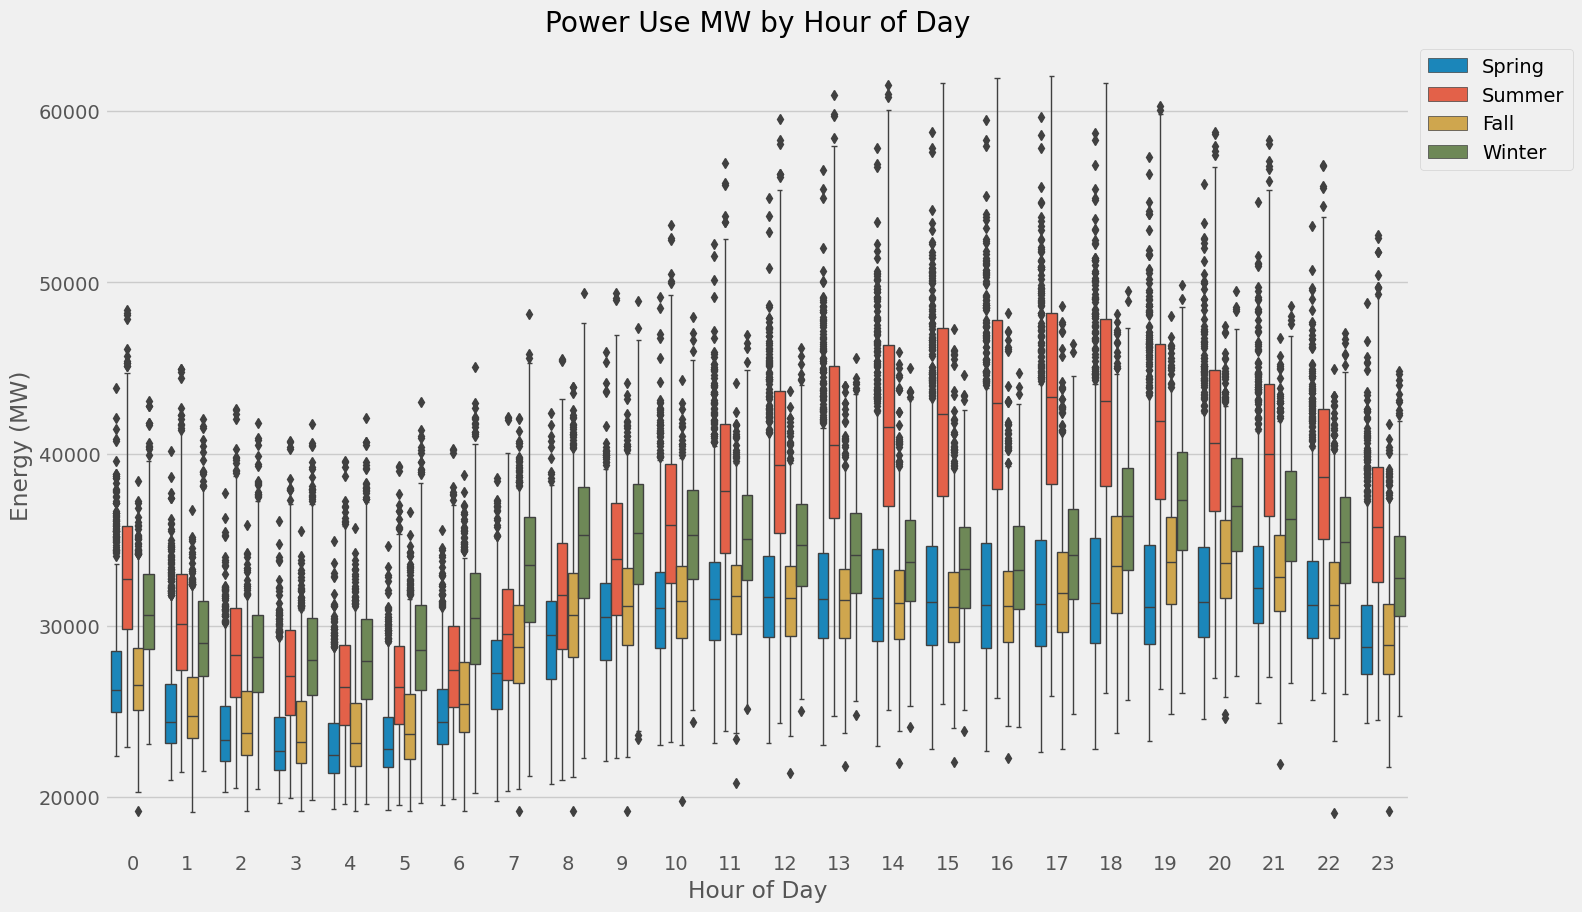

In [828]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.boxplot(data=df_features_lags.dropna(),x='Hour',y='PJME_MW',hue='Season',ax=ax,linewidth=1)

ax.set_title('Power Use MW by Hour of Day')
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Energy (MW)')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

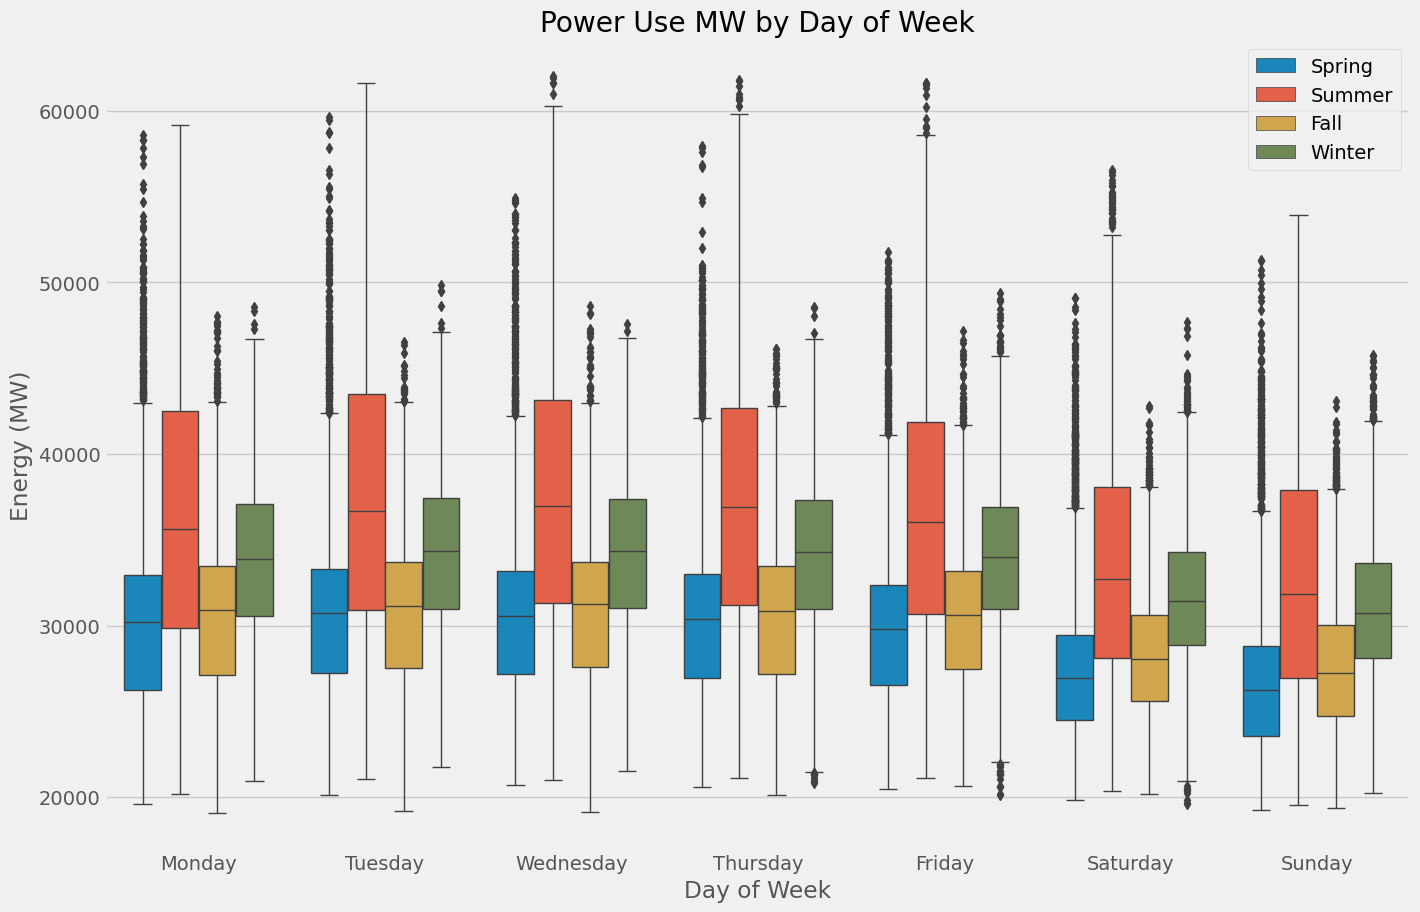

In [829]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.boxplot(data=df_features_lags.dropna(),x='Weekday',y='PJME_MW',hue='Season',ax=ax,linewidth=1)

ax.set_title('Power Use MW by Day of Week')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Energy (MW)')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

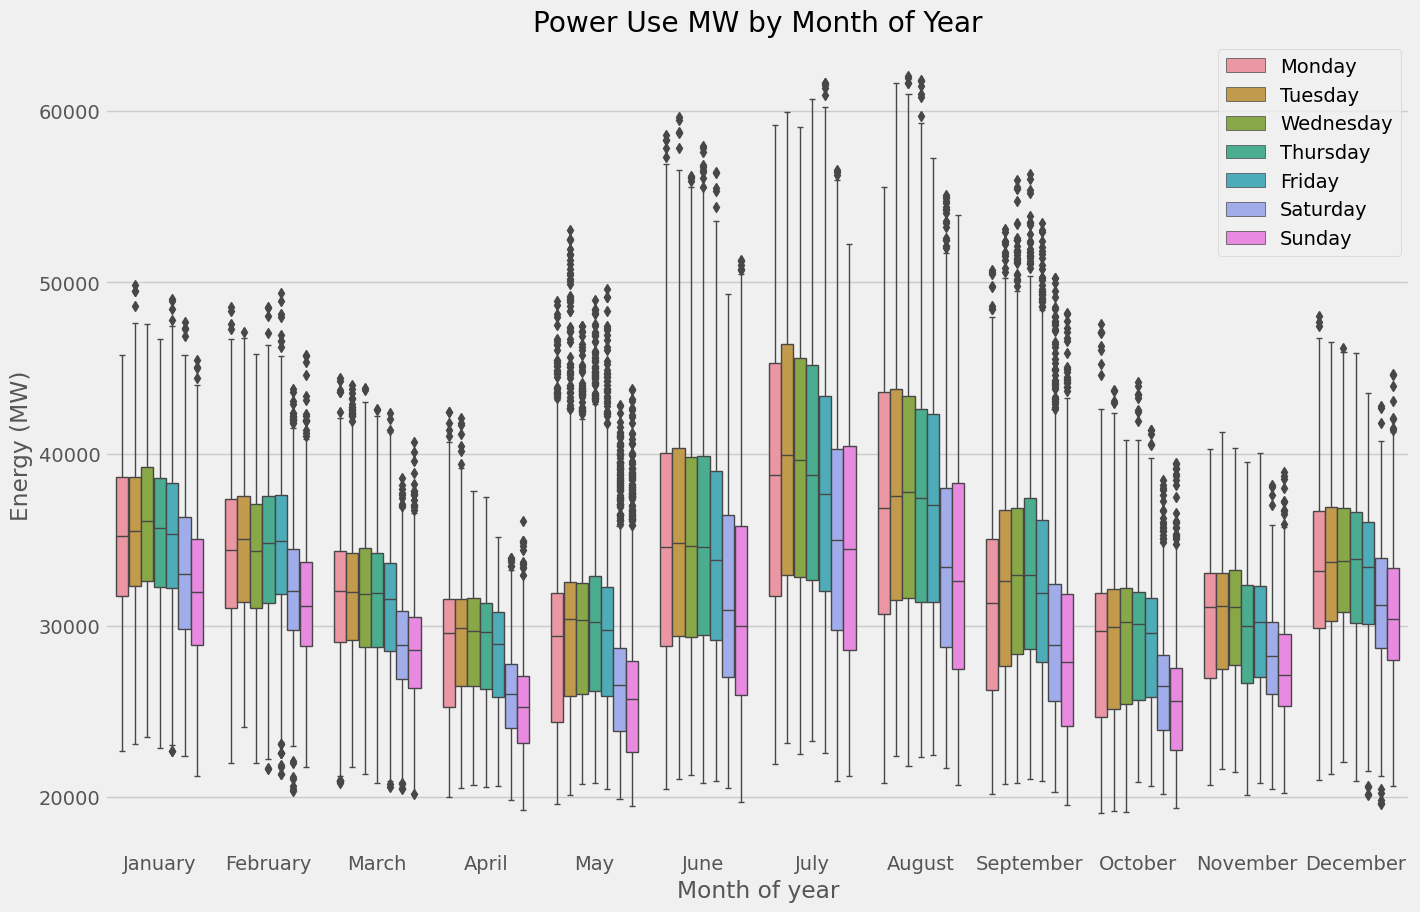

In [830]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.boxplot(data=df_features_lags.dropna(),x='Month',y='PJME_MW',hue='Weekday',ax=ax,linewidth=1)

ax.set_title('Power Use MW by Month of Year')
ax.set_xlabel('Month of year')
ax.set_ylabel('Energy (MW)')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

<hr>

## 3 - Building Machine Learning Models 

In this section I will create the XGBoost and Prophet models and compare them via multiple metrics such as RMSE and MAPE. Based on these metrics I will determine which model will be used for forecasting.

###  3.1 Building XGBoost Model & Error Metrics

In [831]:
%%time
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

fold = 0
preds = []

RMSEs = []
MAEs = []
MAPEs = []

for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    
    
    FEATURES = ['Hour', 
                'Day of Week', 
                'Quarter', 
                'Month of Year', 
                'Year',
                'Day of Year', 
                '1 Day Lag', 
                '2 Day Lag', 
                '3 Day Lag', 
                '1 Week Lag', 
                '2 Week Lag',
                '1 Month Lag', 
                '2 Month Lag',
                '1 Year Lag', 
                '2 Year Lag']
    
    TARGET = 'PJME_MW'

    train_feature = create_features(train)
    test_feature = create_features(test)
    train_feature_lags = add_lags(train_feature)
    test_feature_lags = add_lags(test_feature)

    X_train = train_feature_lags[FEATURES]
    y_train = train_feature_lags[TARGET]

    X_test = test_feature_lags[FEATURES]
    y_test = test_feature_lags[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=2000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=250)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    
    RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
    RMSEs.append(RMSE)
    
    MAE = mean_absolute_error(y_test, y_pred)
    MAEs.append(MAE)
    
    MAPE = mean_absolute_percentage_error(y_test, y_pred)
    MAPEs.append(MAPE)

[16:09:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32728.27662	validation_1-rmse:31953.95599
[250]	validation_0-rmse:3561.71025	validation_1-rmse:3796.46041
[500]	validation_0-rmse:2219.95741	validation_1-rmse:2599.46390
[750]	validation_0-rmse:2158.92101	validation_1-rmse:2533.47098
[963]	validation_0-rmse:2130.56242	validation_1-rmse:2521.96979
[16:10:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32668.13633	validation_1-rmse:32134.40683
[250]	validation_0-rmse:3573.38658	validation_1-rmse:3783.67747
[500]	validation_0-rmse:2247.96908	validation_1-rmse:2550.62065
[750]	validation_0-rmse:21

#### Visualizing the Actual Values vs Model Prediction Values

I visually compare the the actual values with the predicted values generated by the XGBoost Model. Broadly speaking the model was accurate in predicting the actual values--however the model did not capture all the extreme values. The final Split (Test set) is from August 3rd, 2017 to August 3rd, 2018.

In [832]:
test['Prediction'] = reg.predict(X_test)

In [833]:
test

PJME_MW    Prediction
Datetime                                  
2017-08-03 01:00:00  29189.0  28251.052734
2017-08-03 02:00:00  27584.0  28228.882812
2017-08-03 03:00:00  26544.0  28191.345703
2017-08-03 04:00:00  26012.0  28191.345703
2017-08-03 05:00:00  26187.0  28191.345703
...                      ...           ...
2018-08-02 20:00:00  44057.0  45530.070312
2018-08-02 21:00:00  43256.0  44818.160156
2018-08-02 22:00:00  41552.0  42846.410156
2018-08-02 23:00:00  38500.0  39937.605469
2018-08-03 00:00:00  35486.0  36056.113281

[8760 rows x 2 columns]

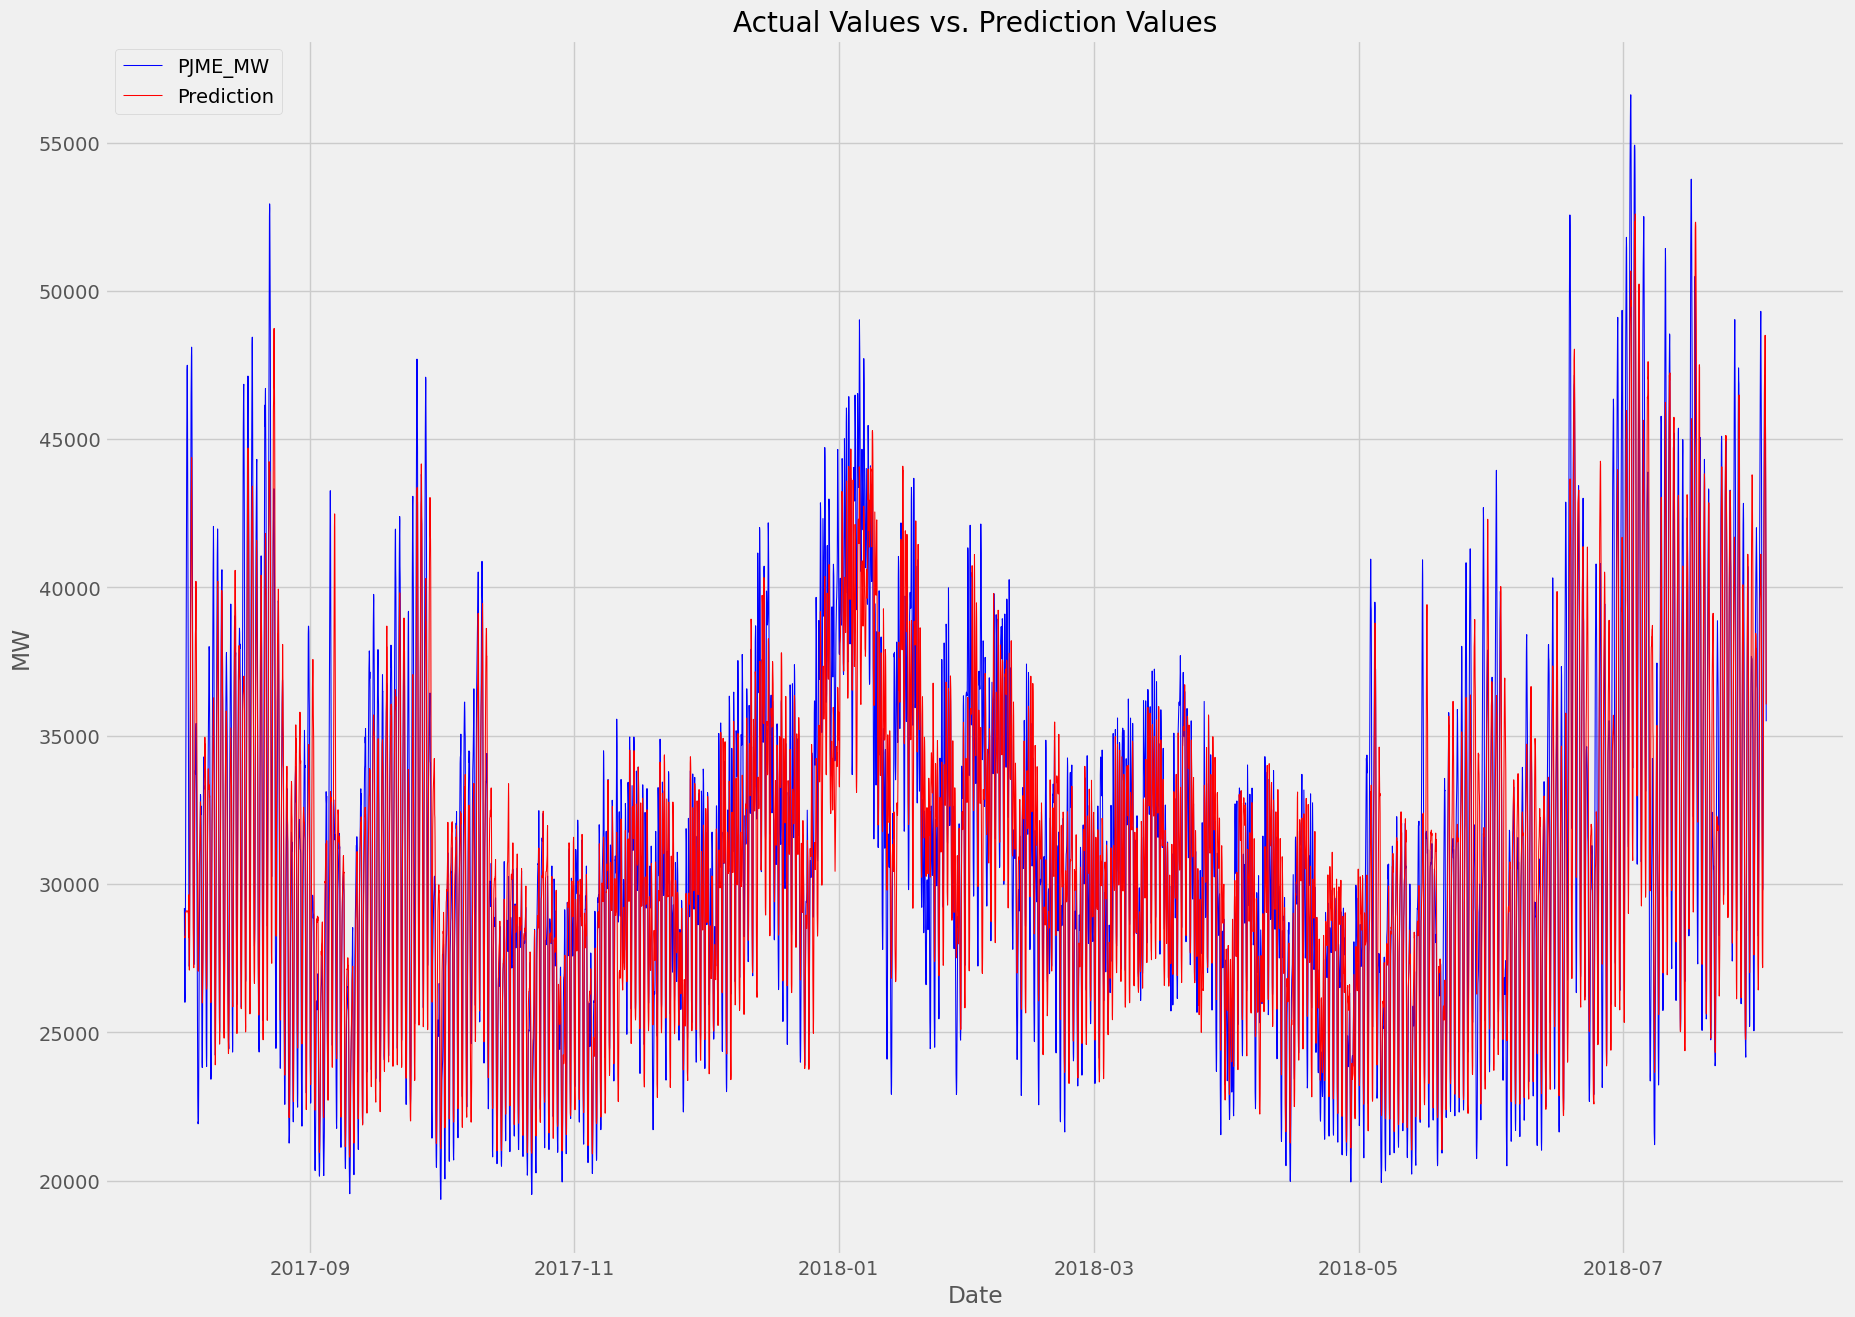

In [834]:
plt.figure(figsize=(20, 15))

plt.plot(test.index, test['PJME_MW'], label='PJME_MW', color='blue', linewidth=.75)
plt.plot(test.index, test['Prediction'], label='Prediction', color='red', linewidth=.75)

# Customize the plot
plt.xlabel('Date')
plt.ylabel('MW')
plt.title('Actual Values vs. Prediction Values')
plt.legend(loc = 2)

# Show the plot
plt.show()


#### RMSE , MAE, and MAPE

The RMSE, MAE, MAPE quantify how well the XGBoost preformed.

In [835]:
# Creating the index column
index_names_XGB = ['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5', 'Fold Avg.']

# Combine the data into a DataFrame
err_met_XGB = {
    'RMSE': RMSEs + [np.mean(RMSEs)],
    'MAE': MAEs + [np.mean(MAEs)],
    'MAPE': MAPEs + [np.mean(MAPEs)]
}

error_metrics_XGB = pd.DataFrame(err_met_XGB, index=index_names)
error_metrics_XGB

RMSE          MAE      MAPE
Fold 1     2514.384890  1854.358479  5.750262
Fold 2     2481.403980  1849.838837  5.709390
Fold 3     2291.429687  1633.359766  5.162016
Fold 4     2593.012890  1898.364318  5.920619
Fold 5     2682.573967  1969.679901  6.153099
Fold Avg.  2512.561083  1841.120260  5.739077

<hr>

### 3.2 Building Prophet Model and Error Metrics

In [836]:
df = pd.read_csv('PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

In [837]:
df.loc[df['PJME_MW'] < 19000, 'PJME_MW'] = np.random.uniform(19000, 19200)

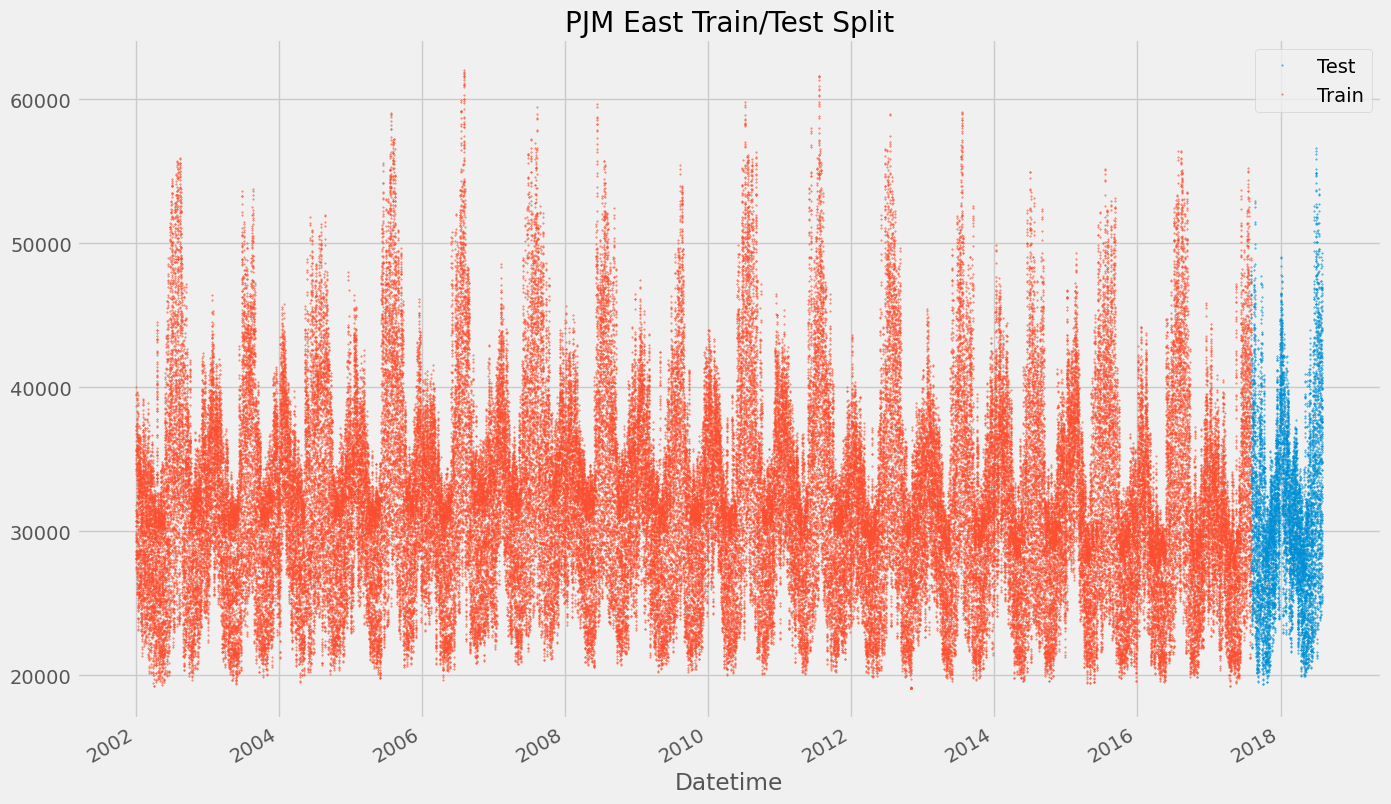

In [838]:
split_date = '3-Aug-2017' # to match the final split of the XGBoost model

df_train = df.loc[df.index < split_date].copy()
df_test = df.loc[df.index >= split_date].copy()

# Plot train and test so you can see where we have split
df_test.rename(columns={'PJME_MW': 'Test'}).join(df_train.rename(columns={'PJME_MW': 'Train'}),
                                                       how='outer').plot(figsize=(15, 10), 
                                                                         title='PJM East Train/Test Split', 
                                                                         style='.', 
                                                                         ms=0.75)

plt.legend()
plt.show()

Prophet modela expect the dataset given to it to be named a specific way. I rename the train and test dataframe columns before feeding it into the model.

* `Datetime` : `ds`
* `PJME_MW` : `y`

In [839]:
df_train_prophet = df_train.reset_index().rename(columns={'Datetime':'ds','PJME_MW':'y'})
df_test_prophet = df_test.reset_index().rename(columns={'Datetime':'ds','PJMW_MW':'y'})

Prophet comes with a Holiday Effects parameter that can be provided to the model prior to training. I will use the built in pandas `USFederalHolidayCalendar` to pull the list of holidays.

In [840]:
cal = calendar() 

holidays = cal.holidays(start=df.index.min(), end = df.index.max(),return_name=True)

holiday_df = pd.DataFrame(data=holidays, columns=['holiday'])

holiday_df = holiday_df.reset_index().rename(columns={'index':'ds'})


In [841]:
%%time
model = Prophet(holidays=holiday_df)
model.fit(df_train_prophet)

21:28:05 - cmdstanpy - INFO - Chain [1] start processing
21:29:28 - cmdstanpy - INFO - Chain [1] done processing


Wall time: 1min 41s


In [842]:
model_test_predict = model.predict(df=df_test_prophet)

#### Visualizing the Actual Values vs Model Prediction Values

Below, I plot the actual values against the values predicted by the Prophet model. By using the plot_components method, I can delve deeper into the time series components of the prediction

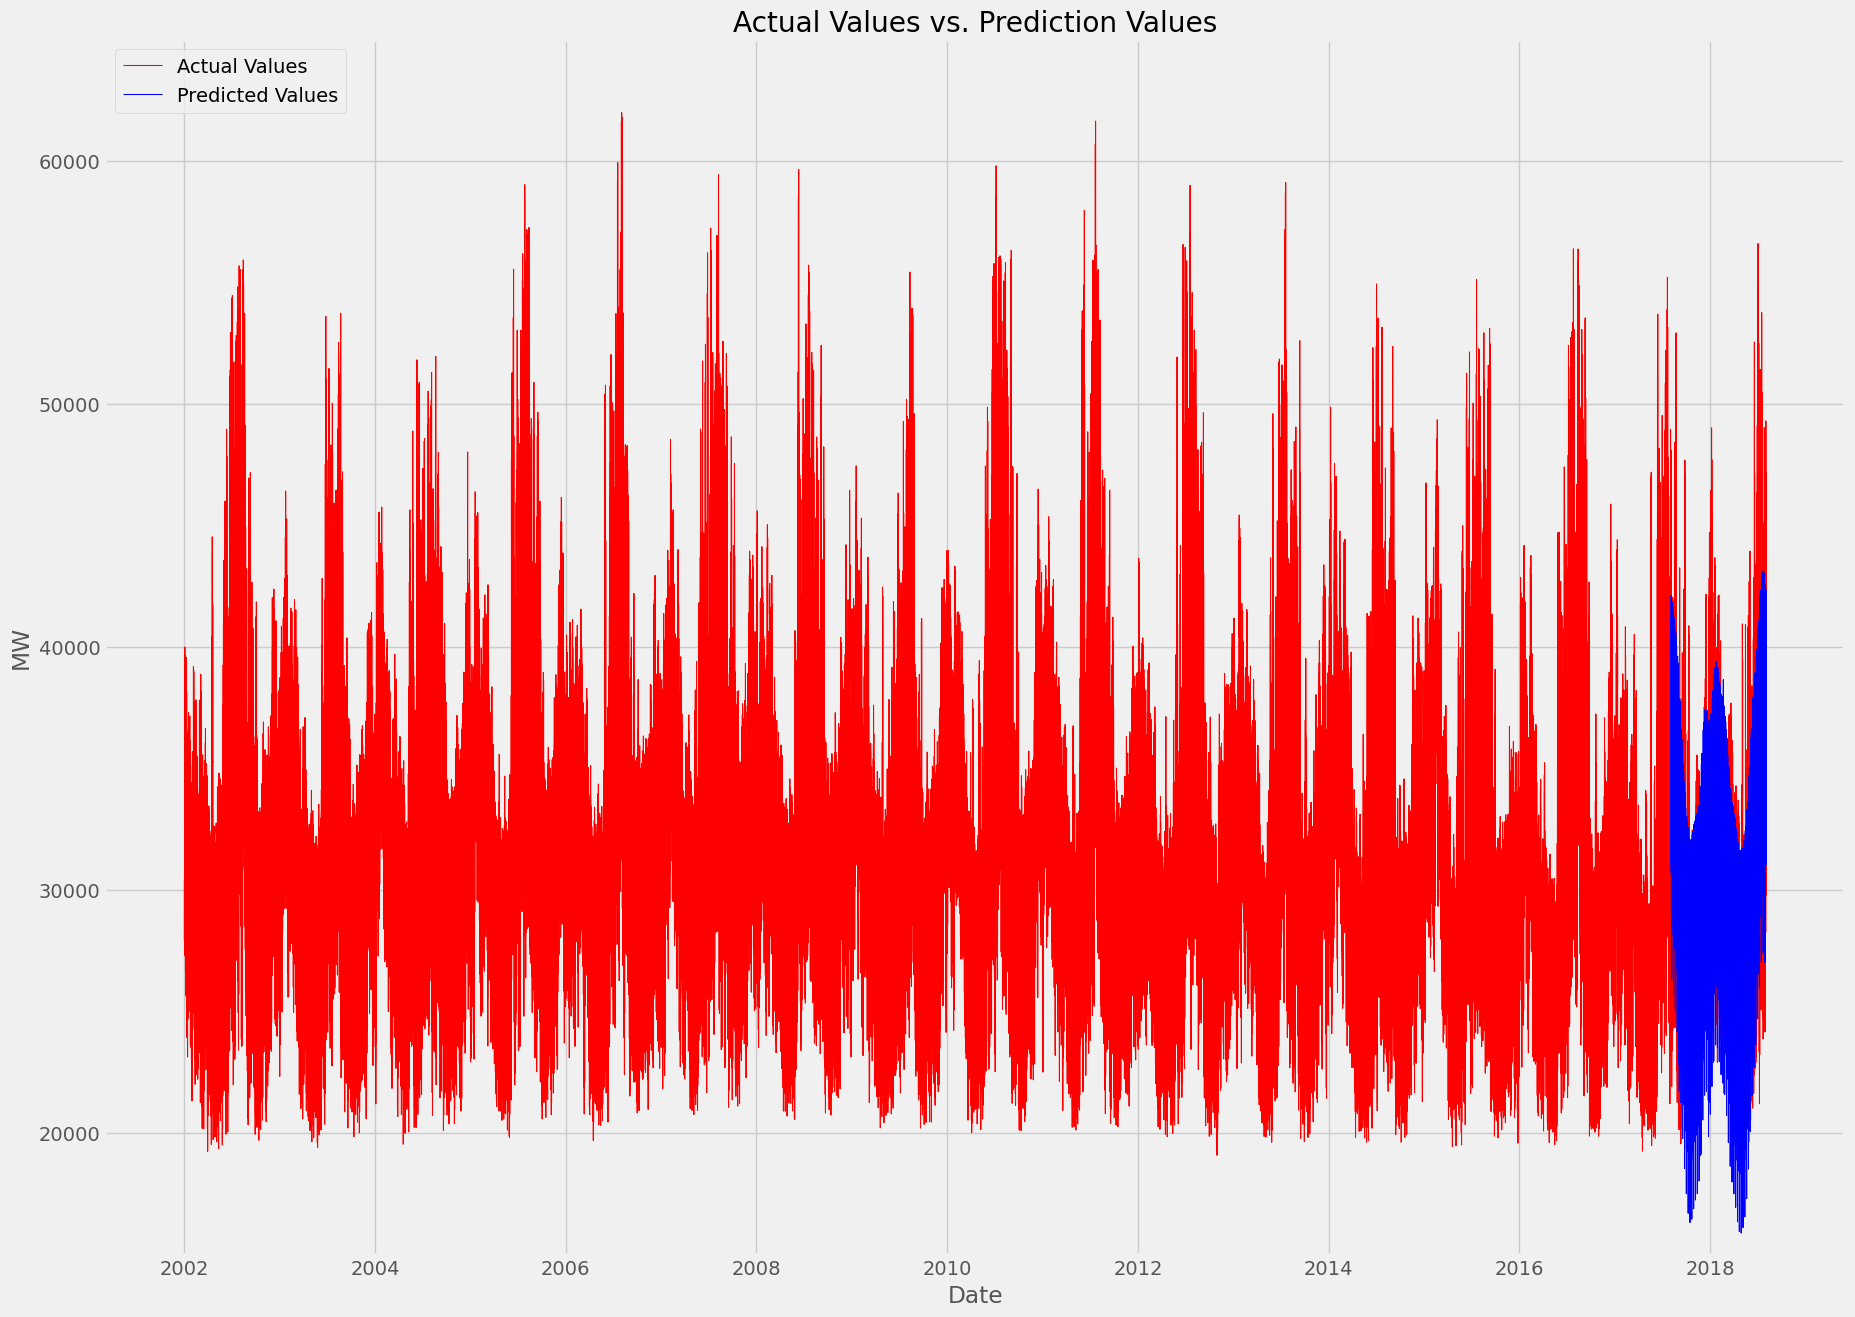

In [864]:
##### df_test = df_test.sort_index()
df_test = df_test[~df_test.index.duplicated(keep='first')]

fig, ax = plt.subplots(figsize=(20, 15))

ax.plot(tester.index, tester['PJME_MW'], color='r', label = 'Actual Values',  linewidth=.75)
ax.plot(model_test_predict['ds'], model_test_predict['yhat'], color='b' ,label = 'Predicted Values',  linewidth=.75)

ax.set_xlabel('Date')
ax.set_ylabel('MW')
ax.set_ylim(15000, 65000)
ax.set_title('Actual Values vs. Prediction Values')
ax.legend(loc = 2)


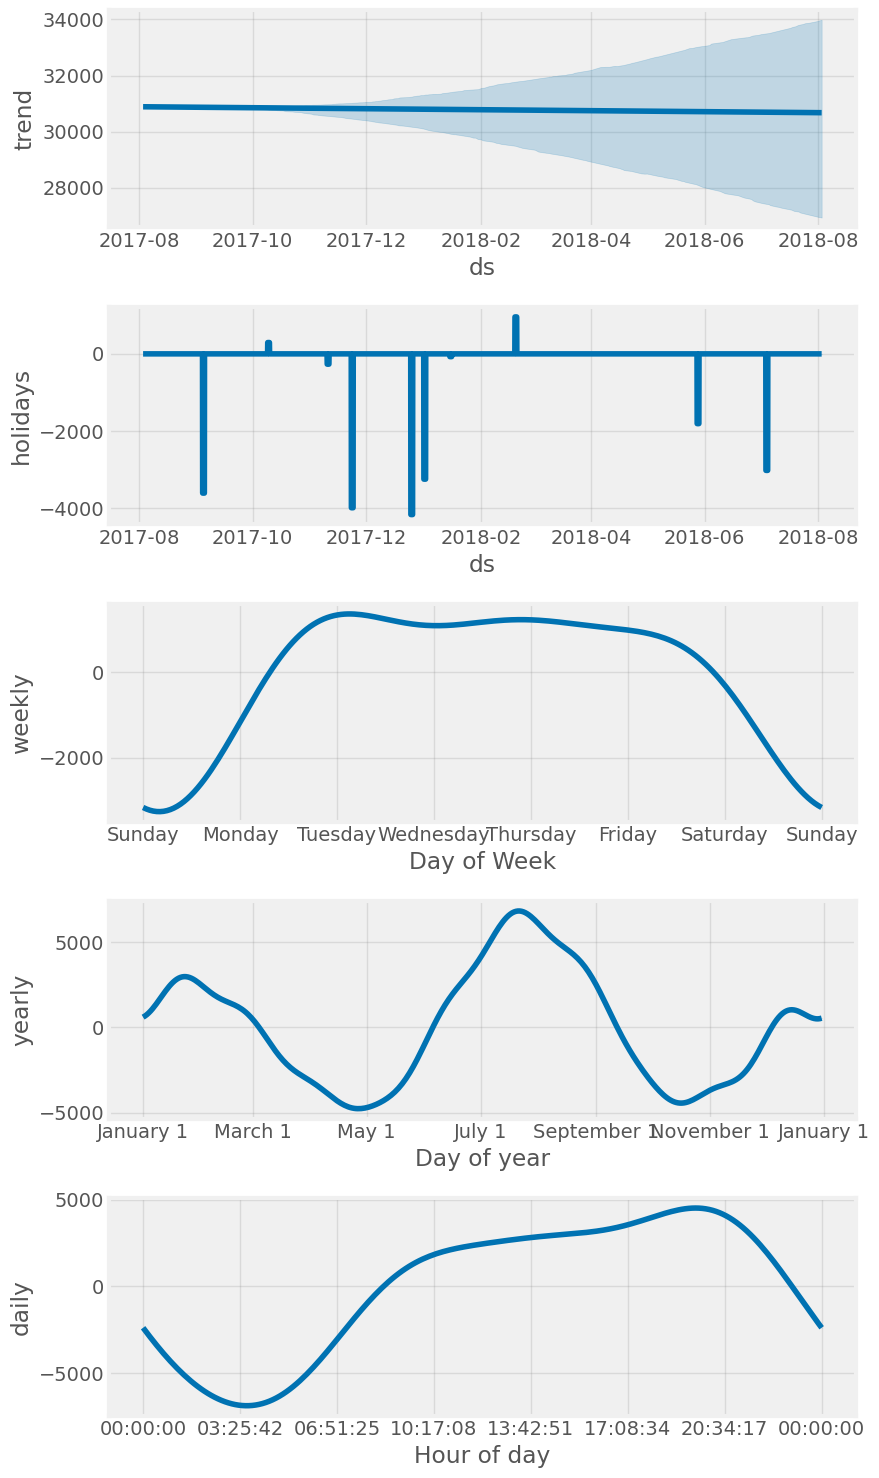

In [844]:
# decomposing the forecast components

model_plot_components = model.plot_components(model_test_predict)

#### Error Metrics 

In [845]:
rmse = np.sqrt(mean_squared_error(y_true=df_test_prophet['PJME_MW'],
                   y_pred=model_test_predict['yhat']))

mae = mean_absolute_error(y_true=df_test_prophet['PJME_MW'],
                   y_pred=model_test_predict['yhat'])

mape = mean_absolute_percentage_error(y_true=df_test_prophet['PJME_MW'],
                   y_pred=model_test_predict['yhat'])


# Creating the index column
index_name = ['Value']

# Combine the data into a DataFrame
err = {
    'RMSE': rmse,
    'MAE': mae,
    'MAPE': mape
}

error_metrics_Prophet = pd.DataFrame(err, index=index_name)
error_metrics_Prophet



RMSE          MAE       MAPE
Value  4788.582285  3793.351167  12.055291

<hr>

## 4 - Selecting a Model 

Now that the XGBoost and Prophet models have been trained and fitted, I compare the error metrics of both to determine which model to use for predicting future energy consumption. I calulate three different error metrics:

* **RMSE**: Measure the differences between predicted values and actual values. It calculates the square root of the average of the squared differences between predicted and actual values. The RMSE is useful as it penalizes larger errors more than smaller errors. Lower RMSE values indicate better model performance, with a value of 0 indicating a perfect fit

* **MAE**: Calculates the average of the absolute differences between predicted and actual values. Lower MAE values indicate better model performance, with a value of 0 indicating a perfect fit.

* **MAPE**: MAPE is a percentage-based metric that measures the accuracy of predictions relative to the actual values. It calculates the average of the absolute percentage differences between predicted and actual values. The MAPE is commonly used because it’s easy to interpret. For example, a MAPE value of 14% means that the average difference between the forecasted value and the actual value is 14%

#### Error Metrics for XGBoost Model

In [846]:
error_metrics_XGB

RMSE          MAE      MAPE
Fold 1     2514.384890  1854.358479  5.750262
Fold 2     2481.403980  1849.838837  5.709390
Fold 3     2291.429687  1633.359766  5.162016
Fold 4     2593.012890  1898.364318  5.920619
Fold 5     2682.573967  1969.679901  6.153099
Fold Avg.  2512.561083  1841.120260  5.739077

#### Error Metrics for Prophet Model

In [847]:
error_metrics_Prophet

RMSE          MAE       MAPE
Value  4788.582285  3793.351167  12.055291

<hr>

In [848]:
print(f'The Average RMSE, MAE and MAPE for the XGBoost model are: {np.mean(RMSEs):0.4f}, {np.mean(MAEs):0.4f}, and {np.mean(MAPEs):0.2f}% respectively')
print( )
print(f'The RMSE, MAE and MAPE for the Prophet model are: {rmse:0.4f}, {mae:0.4f}, and {mape:0.2f}% respectively')


The Average RMSE, MAE and MAPE for the XGBoost model are: 2512.5611, 1841.1203, and 5.74% respectively

The RMSE, MAE and MAPE for the Prophet model are: 4788.5823, 3793.3512, and 12.06% respectively


Regardless of which metric is used it is clear that the XGBoost model outperforms the current Prophet model. Its important to note that the current Prophet does not utilze any Cross Validation methods. Future iterations of this project will include the Prophet's build-in cross validation method. 

Thus my out of sample prediction will use the XGBoost model.

## 5 -  Out of Sample Prediction using XGBoost

To predict out of sample for 1 year, I will have to rerun the model with some minor tweaks. First, I train on all 
available data. Second I reduce the number of estimators from 2000 down to 1000 as this is the average number of steps our model took above.


Since the earliest lag period usied in training the XGBoost model was the `1 Day Lag`, the out of sample predictions will also be a 1 day. If I wanted to create a realiable out of sample prediction for a week the earliest lag period would be the `1 Week Lag` (Similarly for a 1 Month or 1 Year out of sample prediction). However, the less lagged feature the model is trained with the greater the error metrics will be.    

### 5.1 - Training the Model on Entire Data Set

In [849]:
df_OOS = df.copy()

In [850]:
df_OOS.min()

PJME_MW    19085.0
dtype: float64

In [851]:
df_OOS = df_OOS.sort_index()
df_OOS = create_features(df_OOS)
df_OOS = add_lags(df_OOS)

In [852]:
df_OOS

PJME_MW  Hour  Day of Week  Quarter    Month  \
Datetime                                                            
2002-01-01 01:00:00  30393.0     1            1        1  January   
2002-01-01 02:00:00  29265.0     2            1        1  January   
2002-01-01 03:00:00  28357.0     3            1        1  January   
2002-01-01 04:00:00  27899.0     4            1        1  January   
2002-01-01 05:00:00  28057.0     5            1        1  January   
...                      ...   ...          ...      ...      ...   
2018-08-02 20:00:00  44057.0    20            3        3   August   
2018-08-02 21:00:00  43256.0    21            3        3   August   
2018-08-02 22:00:00  41552.0    22            3        3   August   
2018-08-02 23:00:00  38500.0    23            3        3   August   
2018-08-03 00:00:00  35486.0     0            4        3   August   

                     Month of Year  Year  Day of Year  Day of Month  \
Datetime                                                              
2002-01-01 01:00:00              1  2002            1             1   
2002-01-01 02:00:00              1  2002            1             1   
2002-01-01 03:00:00              1  2002            1             1   
2002-01-01 04:00:00              1  2002            1             1   
2002-01-01 05:00:00              1  2002            1             1   
...                            ...   ...          ...           ...   
2018-08-02 20:00:00              8  2018          214             2   
2018-08-02 21:00:00              8  2018          214             2   
2018-08-02 22:00:00              8  2018          214             2   
2018-08-02 23:00:00              8  2018          214             2   
2018-08-03 00:00:00              8  2018          215             3   

                     Week of Year  ...  Season 1 Day Lag  2 Day Lag  \
Datetime                           ...                                
2002-01-01 01:00:00             1  ...  Winter       NaN        NaN   
2002-01-01 02:00:00             1  ...  Winter       NaN        NaN   
2002-01-01 03:00:00             1  ...  Winter       NaN        NaN   
2002-01-01 04:00:00             1  ...  Winter       NaN        NaN   
2002-01-01 05:00:00             1  ...  Winter       NaN        NaN   
...                           ...  ...     ...       ...        ...   
2018-08-02 20:00:00            31  ...  Summer   46912.0    40289.0   
2018-08-02 21:00:00            31  ...  Summer   45985.0    39938.0   
2018-08-02 22:00:00            31  ...  Summer   44094.0    38610.0   
2018-08-02 23:00:00            31  ...  Summer   40666.0    35950.0   
2018-08-03 00:00:00            31  ...  Summer   37158.0    33072.0   

                     3 Day Lag  1 Week Lag  2 Week Lag  1 Month Lag  \
Datetime                                                              
2002-01-01 01:00:00        NaN         NaN         NaN          NaN   
2002-01-01 02:00:00        NaN         NaN         NaN          NaN   
2002-01-01 03:00:00        NaN         NaN         NaN          NaN   
2002-01-01 04:00:00        NaN         NaN         NaN          NaN   
2002-01-01 05:00:00        NaN         NaN         NaN          NaN   
...                        ...         ...         ...          ...   
2018-08-02 20:00:00    36166.0     46337.0     41774.0      49244.0   
2018-08-02 21:00:00    35899.0     44542.0     39779.0      47292.0   
2018-08-02 22:00:00    34879.0     42638.0     38082.0      45506.0   
2018-08-02 23:00:00    32303.0     39276.0     34983.0      42437.0   
2018-08-03 00:00:00    29701.0     35742.0     31740.0      39340.0   

                     2 Month Lag  1 Year Lag  2 Year Lag  
Datetime                                                  
2002-01-01 01:00:00          NaN         NaN         NaN  
2002-01-01 02:00:00          NaN         NaN         NaN  
2002-01-01 03:00:00          NaN         NaN         NaN  
2002-01-01 04:00:00          NaN         NaN         NaN

In [854]:
%%time

FEATURES = ['Hour', 
            'Day of Week', 
            'Quarter', 
            'Month of Year', 
            'Year',
            'Day of Year', 
            '1 Day Lag', 
            '2 Day Lag', 
            '3 Day Lag', 
            '1 Week Lag', 
            '2 Week Lag',
            '1 Month Lag', 
            '2 Month Lag',
            '1 Year Lag', 
            '2 Year Lag']
    
TARGET = 'PJME_MW'

X_all = df_OOS[FEATURES]
y_all = df_OOS[TARGET]

reg_all = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1500,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
reg_all.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[21:33:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32458.34525	validation_1-rmse:31464.06853
[100]	validation_0-rmse:12155.06881	validation_1-rmse:11725.39497
[200]	validation_0-rmse:5008.74520	validation_1-rmse:5090.01045
[300]	validation_0-rmse:2851.56557	validation_1-rmse:3217.61262
[400]	validation_0-rmse:2371.94021	validation_1-rmse:2818.79150
[500]	validation_0-rmse:2269.91751	validation_1-rmse:2735.25603
[600]	validation_0-rmse:2237.65730	validation_1-rmse:2714.31100
[700]	validation_0-rmse:2218.63146	validation_1-rmse:2706.79118
[800]	validation_0-rmse:2202.88883	validation_1-rmse:2705.53309
[900]	validation_0-rmse:2190.39063	validation_1-rmse:2698.98022
[1000]	validation_0-rmse:2180.71176	validation_1-rmse:2695.22171
[1100]	validation_0-rmse:2172.29018	validation_1-rmse:2692.217

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1500, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

### 5.2 - Creating Out of Sample Dataframe

Now I create the skeleton dataframe of our prediction our start date will be the last data point available in our data

In [855]:
df_OOS.sort_index().index.max() # to run find the first date of prediction

Timestamp('2018-08-03 00:00:00')

In [856]:
df_OOS = df_OOS.iloc[:-1 , :]

In [857]:
# Create future dataframe
future = pd.date_range('2018-08-03','2018-08-04', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True

df_OOS['isFuture'] = False
df_and_future = pd.concat([df_OOS, future_df])
df_and_future = create_features(df_and_future, pred = True)
df_and_future = add_lags(df_and_future)

In [858]:
future_w_features = df_and_future.query('isFuture == True').copy()
future_w_features = future_w_features.iloc[:-1 , :]
future_w_features # note that this df has all features but no values for 'PJME_MW'

PJME_MW  isFuture  Hour  Day of Week  Quarter   Month  \
2018-08-03 00:00:00      NaN      True     0            4        3  August   
2018-08-03 01:00:00      NaN      True     1            4        3  August   
2018-08-03 02:00:00      NaN      True     2            4        3  August   
2018-08-03 03:00:00      NaN      True     3            4        3  August   
2018-08-03 04:00:00      NaN      True     4            4        3  August   
2018-08-03 05:00:00      NaN      True     5            4        3  August   
2018-08-03 06:00:00      NaN      True     6            4        3  August   
2018-08-03 07:00:00      NaN      True     7            4        3  August   
2018-08-03 08:00:00      NaN      True     8            4        3  August   
2018-08-03 09:00:00      NaN      True     9            4        3  August   
2018-08-03 10:00:00      NaN      True    10            4        3  August   
2018-08-03 11:00:00      NaN      True    11            4        3  August   
2018-08-03 12:00:00      NaN      True    12            4        3  August   
2018-08-03 13:00:00      NaN      True    13            4        3  August   
2018-08-03 14:00:00      NaN      True    14            4        3  August   
2018-08-03 15:00:00      NaN      True    15            4        3  August   
2018-08-03 16:00:00      NaN      True    16            4        3  August   
2018-08-03 17:00:00      NaN      True    17            4        3  August   
2018-08-03 18:00:00      NaN      True    18            4        3  August   
2018-08-03 19:00:00      NaN      True    19            4        3  August   
2018-08-03 20:00:00      NaN      True    20            4        3  August   
2018-08-03 21:00:00      NaN      True    21            4        3  August   
2018-08-03 22:00:00      NaN      True    22            4        3  August   
2018-08-03 23:00:00      NaN      True    23            4        3  August   

                     Month of Year  Year  Day of Year  Day of Month  ...  \
2018-08-03 00:00:00              8  2018          215             3  ...   
2018-08-03 01:00:00              8  2018          215             3  ...   
2018-08-03 02:00:00              8  2018          215             3  ...   
2018-08-03 03:00:00              8  2018          215             3  ...   
2018-08-03 04:00:00              8  2018          215             3  ...   
2018-08-03 05:00:00              8  2018          215             3  ...   
2018-08-03 06:00:00              8  2018          215             3  ...   
2018-08-03 07:00:00              8  2018          215             3  ...   
2018-08-03 08:00:00              8  2018          215             3  ...   
2018-08-03 09:00:00              8  2018          215             3  ...   
2018-08-03 10:00:00              8  2018          215             3  ...   
2018-08-03 11:00:00              8  2018          215             3  ...   
2018-08-03 12:00:00              8  2018          215             3  ...   
2018-08-03 13:00:00              8  2018          215             3  ...   
2018-08-03 14:00:00              8  2018          215             3  ...   
2018-08-03 15:00:00              8  2018          215             3  ...   
2018-08-03 16:00:00              8  2018          215             3  ...   
2018-08-03 17:00:00              8  2018          215             3  ...   
2018-08-03 18:00:00              8  2018          215             3  ...   
2018-08-03 19:00:00              8  2018          215             3  ...   
2018-08-03 20:00:00              8  2018          215             3  ...   
2018-08-03 21:00:00              8  2018          215             3  ...   
2018-08-03 22:00:00              8  2018          215             3  ...   
2018-08-03 23:00:00              8  2018          215             3  ...   

                     Season 1 Day Lag 2 Day Lag  3 Day Lag  1 Week Lag  \
2018-08-03 00:00:00  Summer   37158.0   33072.0    29701.0     35742.0   
2018-08-03 01:00:00  

#### Making the Future Prediction

In [859]:
future_w_features['Prediction'] = reg.predict(future_w_features[FEATURES]) # making a prediction usign the features 

<AxesSubplot:title={'center':'MW Consumption Prediction for 8/3/2018'}>

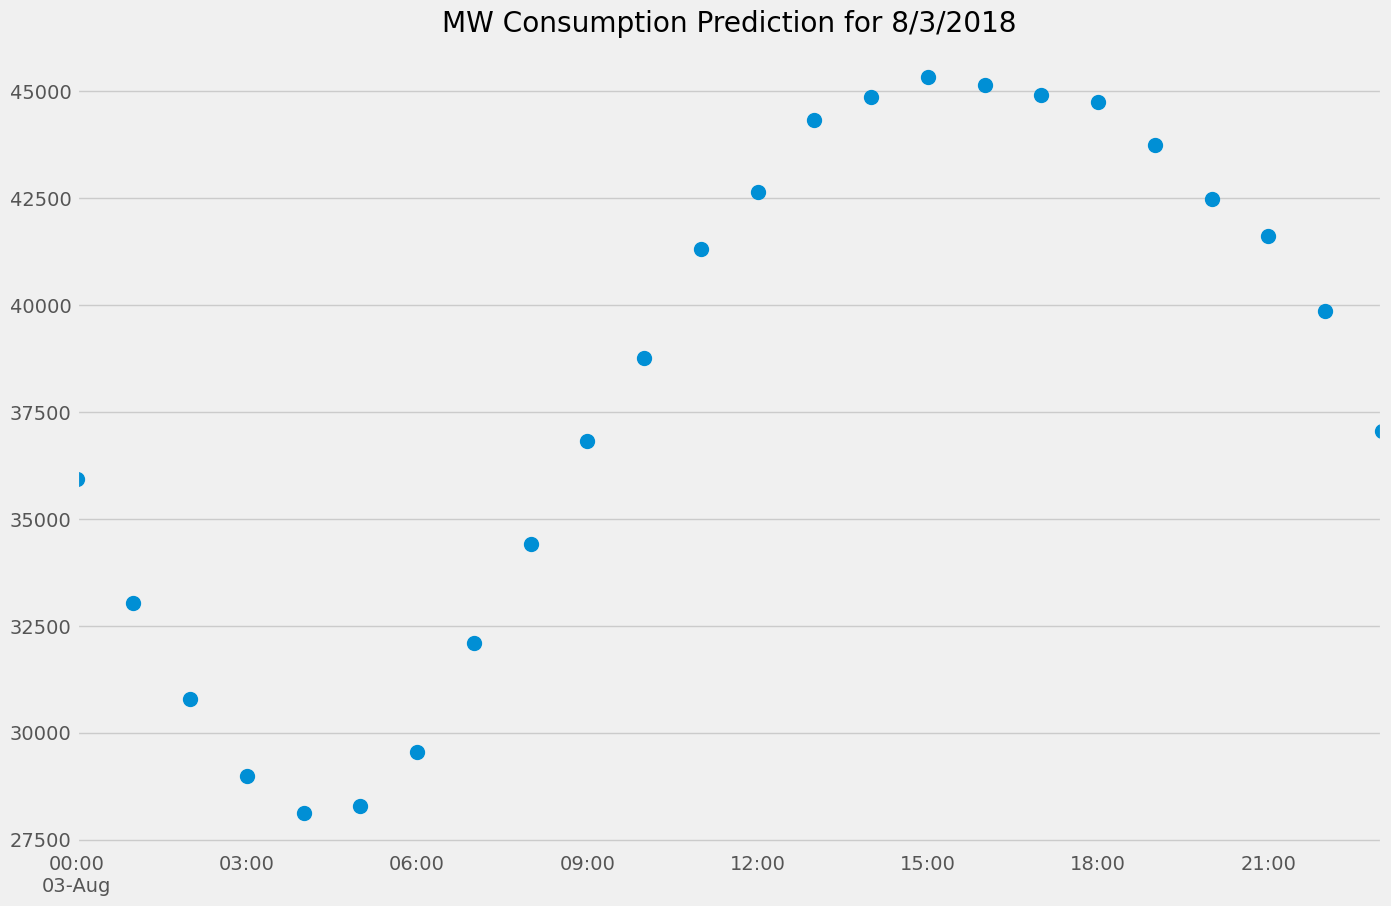

In [868]:
future_w_features['Prediction'].plot(style='.',figsize=(15, 10),ms= 20,title='MW Consumption Prediction for 8/3/2018')

Comparing the out-of-sample prediction plot to the plot of historical power usage in a given day, we see that our prediction visually falls within the interquartile range of what one could expect on a given day in the summer season. Thus I feel confident that the predictions made are reasonable enough.

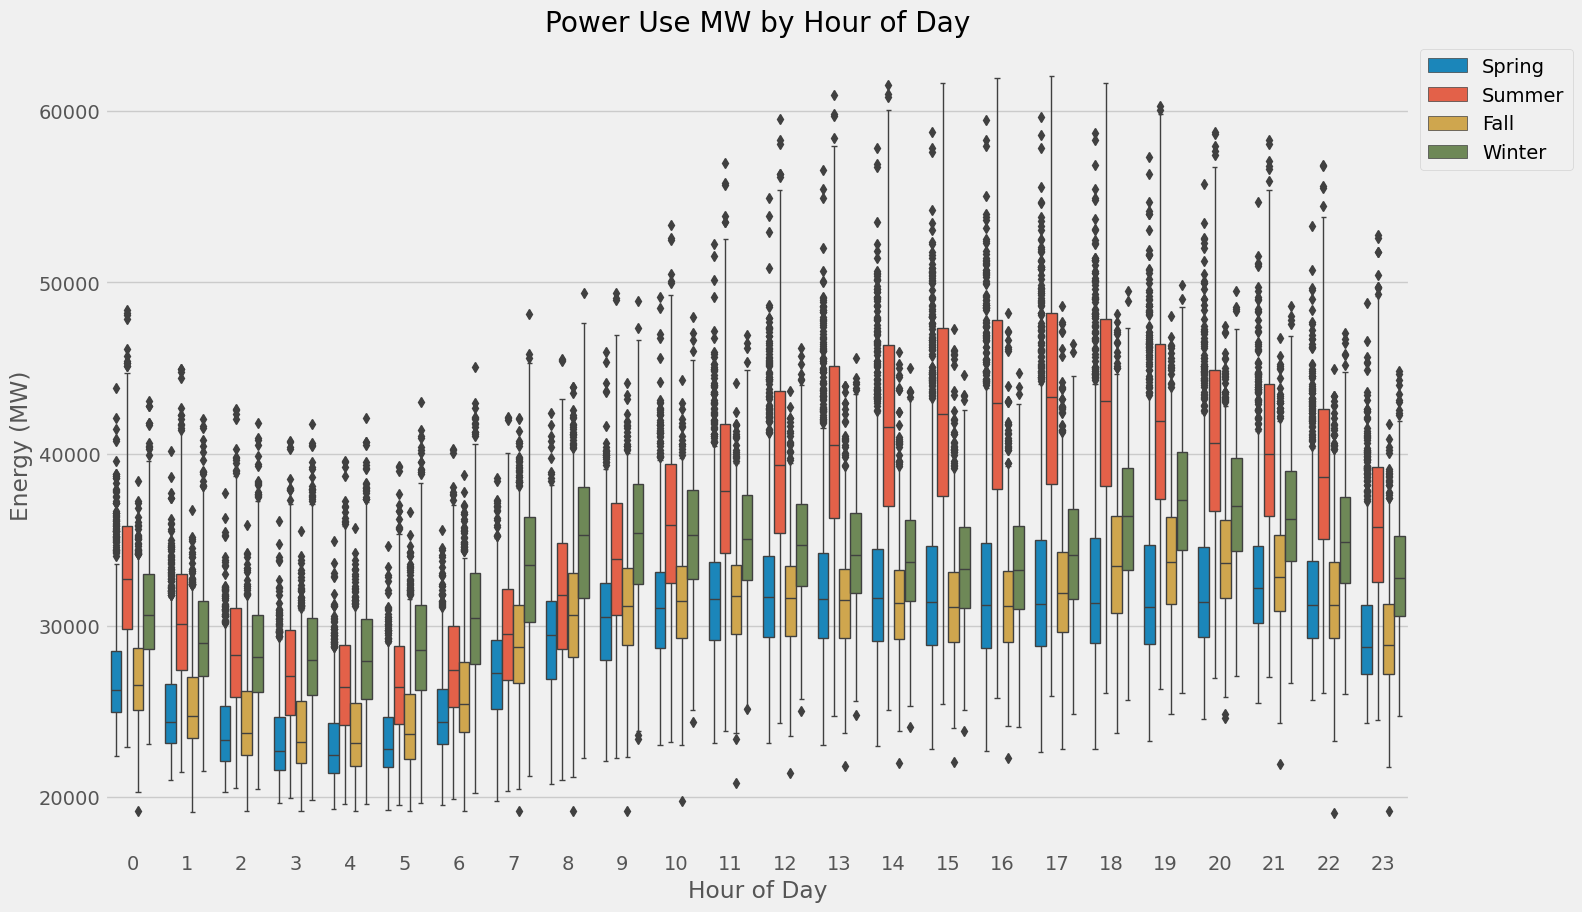

In [862]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.boxplot(data=df_features_lags.dropna(), x='Hour', y='PJME_MW', hue='Season',ax=ax, linewidth=1)
ax.set_title('Power Use MW by Hour of Day')
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Energy (MW)')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

<hr>

## 6 - Concluding Remarks & Saving the Model

In this project, I used roughly 16 years of PJM energy consumption data to train two different supervised machine learning models—XGBoost and Prophet. After visualizing the data and building the ML models, I used the error metrics RMSE, MAE, and MAPE to determine that the XGBoost model was optimal for out-of-sample prediction. Lastly, I created an out-of-sample prediction for one day, as the earliest lag period used in training the model was a 1-day lag.

Currently, there are two major changes I would consider for future iterations of this project:

1. I would try to understand how the Prophet's cross_validation method works so that I can properly compare the two models.

2. I would also like to incorporate other exogenous regressors into the model. Examples would include weather data (such as whether it rained or snowed at a particular time), temperature data, and calculating moving averages of various regressors.

Lastly I will save the model so I can pick up where I left off when new data is availible to train on.

In [865]:
reg.save_model('xgboost_PJME_MW.json') # now I can call this model directly

Just as proof that the model is saved.

<AxesSubplot:title={'center':'MW Consumption Prediction for 8/3/2018'}>

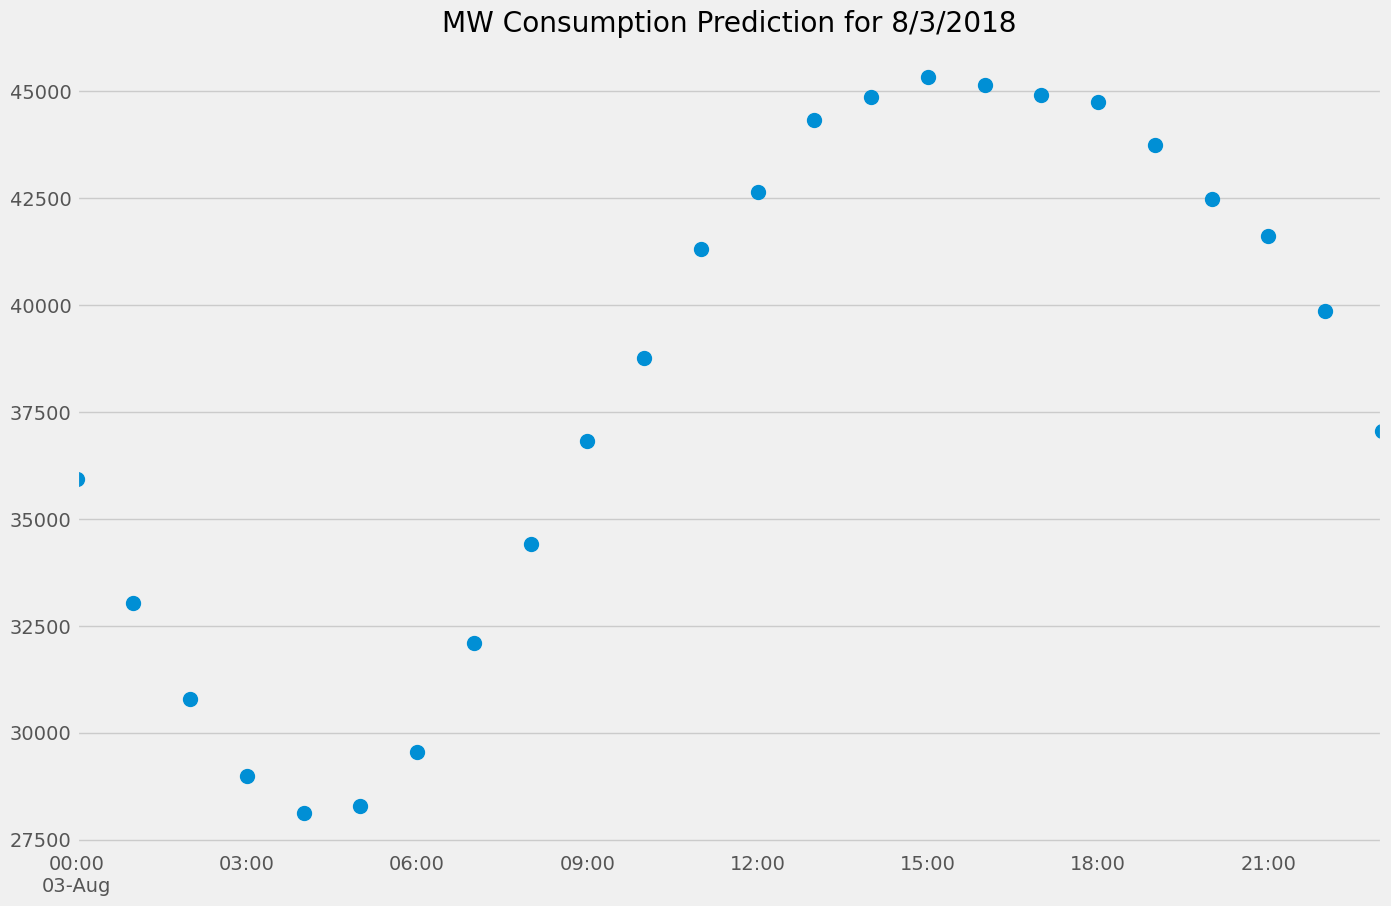

In [877]:
reg_new = xgb.XGBRegressor()

reg_new.load_model('xgboost_PJME_MW.json')

future_w_features['Prediction'] = reg_new.predict(future_w_features[FEATURES])
future_w_features['Prediction'].plot(style = '.',figsize = (15, 10),ms = 20,title='MW Consumption Prediction for 8/3/2018')